# Imports

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pmesh.pm import ParticleMesh as PMnew
from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower, MultipleSpeciesCatalog
from matplotlib.colors import LogNorm
from scipy.integrate import simps
from time import time
from nbodykit.cosmology.cosmology import Cosmology

from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d

import os, sys


Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append("../code/utils/")
import features as ft
import tools
from scipy.optimize import minimize



In [4]:
def laplace(k, v):
    kk = sum(ki ** 2 for ki in k)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    b = v / kk
    b[mask] = 0
    return b



def gradient(dir, order=1):
    if order == 0:
        def kernel(k, v):
            # clear the nyquist to ensure field is real                         
            mask = v.i[dir] != v.Nmesh[dir] // 2
            return v * (1j * k[dir]) * mask
    if order == 1:
        def kernel(k, v):
            cellsize = (v.BoxSize[dir] / v.Nmesh[dir])
            w = k[dir] * cellsize

            a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
            # a is already zero at the nyquist to ensure field is real          
            return v * (1j * a)
    return kernel



def doza(dlin_k, q, resampler='cic', z=0, displacement=False):
    """ Run first order LPT on linear density field, returns displacements of particles            
        reading out at q. The result has the same dtype as q.                                      
    """
    basepm = dlin_k.pm

    ndim = len(basepm.Nmesh)
    delta_k = basepm.create('complex')
    source = numpy.zeros((len(q), ndim), dtype=q.dtype)
    for d in range(len(basepm.Nmesh)):
        disp = dlin_k.apply(laplace) \
                    .apply(gradient(d), out=Ellipsis) \
                    .c2r(out=Ellipsis)
        source[..., d] = disp.readout(q, resampler=resampler)*dgrow(z)
        
    if displacement: return source
    pos = q + source
    pos[pos < 0] += bs
    pos[pos > bs] -= bs
    return pos

sig80 = 0.8222
cosmodef = {'omegam':0.309167, 'h':0.677, 'omegab':0.048}
cosmo = Cosmology.from_dict(cosmodef)
dgrow = cosmo.scale_independent_growth_factor
klin, plin = np.loadtxt('../data/pklin_1.0000.txt', unpack=True)

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): omegab, omegam
  self.engine = ClassEngine(pars)


# Bias Model

In [5]:
bs, nc = 256., 128
aa = 0.3333
zz = 1/aa-1
pm = PMnew(BoxSize=bs, Nmesh=[nc, nc, nc], dtype = "f8")

hmesh = BigFileMesh('/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/fastpm_%0.4f/HImesh-N%04d/'%(aa, nc), 'ModelA').paint()
hmeshrsd = BigFileMesh('/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/fastpm_%0.4f/HImeshz-N%04d/'%(aa, nc), 'ModelA').paint()

hmesh /= hmesh.cmean()
hmesh -= 1
hmeshrsd /= hmeshrsd.cmean()
hmeshrsd -= 1



In [6]:
lin = BigFileMesh('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/%d-%d-9100-fixed/linear/'%(bs, nc), 'LinearDensityK').paint()
ones = pm.create(type='real', value=1.)

grid = pm.mesh_coordinates()*bs/nc

zapos = doza(lin.r2c(), grid, z=zz)
za = pm.paint(zapos)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


In [7]:
print(aa)
dyn = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/256-128-9100-fixed/fastpm_%0.4f/1'%aa)
fin = pm.paint(dyn['Position'])

rsdfac = 0 
with open('/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/fastpm_%0.4f/Header/attr-v2'%aa) as ff:
    for line in ff.readlines():
        if 'RSDFactor' in line: rsdfac = float(line.split()[-2])
print(rsdfac)            
los = np.array([0, 0, 1]).reshape(1, -1)

fin = pm.paint(dyn['Position'])

fin /= fin.cmean()
fin -= 1

fpos = dyn['Position'].compute()
fpos[fpos < 0] += bs
fpos[fpos > bs] -= bs

finsm = ft.smooth(fin, 3, 'gauss')
dm = pm.paint(fpos)


0.3333
0.00997877


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


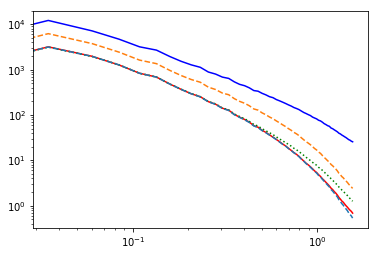

In [8]:
k = FFTPower(fin, mode='1d').power['k']
pf = FFTPower(fin, mode='1d').power['power']
pza = FFTPower(za, mode='1d').power['power']
pxfza = FFTPower(za, second=fin, mode='1d').power['power']
ph = FFTPower(hmesh, mode='1d').power['power']
pxfh = FFTPower(hmesh, second=fin, mode='1d').power['power']

# plt.plot(k, (pf/ph)**0.5)
plt.plot(k, pf, 'r')
plt.plot(k, pza, 'g:')
plt.plot(k, pxfza, '--')
plt.plot(k, ph, 'b')
plt.plot(k, pxfh, '--')
plt.xscale('log')
plt.yscale('log')


# Testing

In [294]:
d0 = lin.copy()

d2 = 1.*lin**2
d2 -= d2.cmean()

s2 = ft.shear(pm, lin)
s2 -= 1.*lin**2
s2 -= s2.cmean()

# d0 = finsm.copy()

# d2 = 1.*finsm**2
# d2 -= d2.cmean()

# s2 = ft.shear(pm, finsm)
# s2 -= 1.*finsm**2
# s2 -= s2.cmean()



In [295]:
# plt.plot(k, FFTPower(s2, mode='1d').power['power'])
# plt.plot(k, FFTPower(s2, second=d2, mode='1d').power['power'])
# plt.plot(k, -FFTPower(s2, second=d2, mode='1d').power['power'])
# plt.loglog()

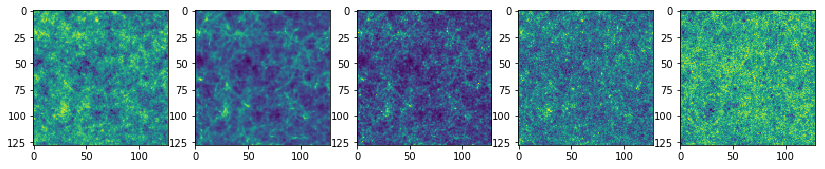

In [296]:
ii = 5

plt.figure(figsize = (14, 4))

plt.subplot(1,ii,1)
plt.imshow(lin[...].sum(axis=0))

plt.subplot(1,ii,2)
plt.imshow(fin[...].sum(axis=0))

plt.subplot(1,ii,3)
plt.imshow(hmesh[...].sum(axis=0))

plt.subplot(1,ii,4)
plt.imshow(d2[...].sum(axis=0))

plt.subplot(1,ii,5)
plt.imshow(s2[...].sum(axis=0))


[1. 1. 1. ... 1. 1. 1.]


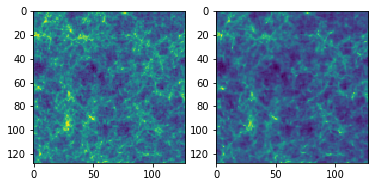

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


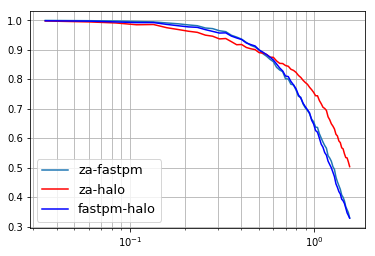

In [297]:
base = 1.*ones**1
# base = 1.*lin**2- (lin**2).cmean()
# base = 1.*s2
rd = base.readout(grid, resampler='nearest')
print(rd)

t1 = pm.paint(zapos, mass=rd, resampler='cic')
t2 = pm.paint(fpos, mass=rd, resampler='cic')

plt.subplot(121)
plt.imshow(t1[...].sum(axis=0))
plt.subplot(122)
plt.imshow(t2[...].sum(axis=0))
plt.show()

k = FFTPower(t1, mode='1d').power['k']
pt1 = FFTPower(t1, mode='1d').power['power']
pt2 = FFTPower(t2, mode='1d').power['power']
pxt12 = FFTPower(t1, second=t2, mode='1d').power['power']

plt.plot(k, pxt12**2/pt1/pt2, label='za-fastpm')
plt.xscale('log')
plt.grid(which='both')

pxt1h = FFTPower(t1, second=hmesh, mode='1d').power['power']
pxt2h = FFTPower(t2, second=hmesh, mode='1d').power['power']
plt.plot(k, pxt1h**2/ph/pt1, 'r', label='za-halo')
plt.plot(k, pxt2h**2/ph/pt2, 'b', label='fastpm-halo')
plt.legend(fontsize=13)
# PLT.YLABEL('rc')

In [298]:
# pos = fposfpm.copy()
# pos = fpos.copy()
pos =  zapos.copy()
ed = pm.paint(pos, mass=ones.readout(grid, resampler='nearest'))
ed0 = pm.paint(pos, mass=d0.readout(grid, resampler='nearest'))
ed2 = pm.paint(pos, mass=d2.readout(grid, resampler='nearest'))
es2 = pm.paint(pos, mass=s2.readout(grid, resampler='nearest'))
# ed = pm.create(type='real', value=0)
# ed0 = d0.copy()
# ed2 = d2.copy()
# es2 = s2.copy()

# ed /= ed.cmean()
# ed0 /= ed0.cmean()
# ed2 /= ed2.cmean()
# es2 /= es2.cmean()

ped = FFTPower(ed, mode='1d').power['power']
ped0 = FFTPower(ed0, mode='1d').power['power']
ped2 = FFTPower(ed2, mode='1d').power['power']
pes2 = FFTPower(es2, mode='1d').power['power']

pxedd0 = FFTPower(ed, second=ed0, mode='1d').power['power']
pxedd2 = FFTPower(ed, second=ed2, mode='1d').power['power']
pxeds2 = FFTPower(ed, second=es2, mode='1d').power['power']

pxed0d2 = FFTPower(ed0, second=ed2, mode='1d').power['power']
pxed0s2 = FFTPower(ed0, second=es2, mode='1d').power['power']
pxed2s2 = FFTPower(ed2, second=es2, mode='1d').power['power']

pxhed = FFTPower(hmesh, second=ed, mode='1d').power['power']
pxhed0 = FFTPower(hmesh, second=ed0, mode='1d').power['power']
pxhed2 = FFTPower(hmesh, second=ed2, mode='1d').power['power']
pxhes2 = FFTPower(hmesh, second=es2, mode='1d').power['power']




In [299]:
# ped = FFTPower(ed/ed.cmean(), mode='1d').power['power']
# ped0 = FFTPower(ed0/ed0.cmean(), mode='1d').power['power']
# ped2 = FFTPower(ed2/ed2.cmean(), mode='1d').power['power']
# pes2 = FFTPower(es2/es2.cmean(), mode='1d').power['power']

# pxedd0 = FFTPower(ed/ed.cmean(), second=ed0/ed0.cmean(), mode='1d').power['power']
# pxedd2 = FFTPower(ed/ed.cmean(), second=ed2/ed2.cmean(), mode='1d').power['power']
# pxeds2 = FFTPower(ed/ed.cmean(), second=es2/es2.cmean(), mode='1d').power['power']

# pxed0d2 = FFTPower(ed0/ed0.cmean(), second=ed2/ed2.cmean(), mode='1d').power['power']
# pxed0s2 = FFTPower(ed0/ed0.cmean(), second=es2/es2.cmean(), mode='1d').power['power']
# pxed2s2 = FFTPower(ed2/ed2.cmean(), second=es2/es2.cmean(), mode='1d').power['power']

# pxhed = FFTPower(hmesh, second=ed/ed.cmean(), mode='1d').power['power']
# pxhed0 = FFTPower(hmesh, second=ed0/ed0.cmean(), mode='1d').power['power']
# pxhed2 = FFTPower(hmesh, second=ed2/ed2.cmean(), mode='1d').power['power']
# pxhes2 = FFTPower(hmesh, second=es2/es2.cmean(), mode='1d').power['power']



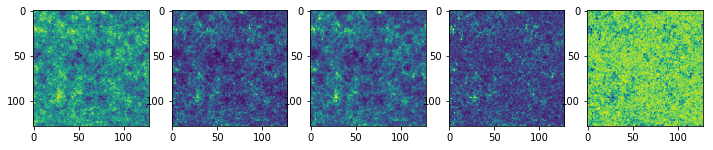

In [300]:
ii = 5

plt.figure(figsize = (12, 4))

plt.subplot(1,ii,1)
plt.imshow(lin[...].sum(axis=0))

plt.subplot(1,ii,2)
plt.imshow(hmesh[...].sum(axis=0))

plt.subplot(1,ii,3)
plt.imshow(ed0[...].sum(axis=0))

plt.subplot(1,ii,4)
plt.imshow(ed2[...].sum(axis=0))

plt.subplot(1,ii,5)
plt.imshow(es2[...].sum(axis=0))


# constant bias model

In [301]:
def ftomin(bb, ii=10, retp = False):
    b1, b2, bs = bb
    pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
    pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
#     pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 
    
    predx = 1*b1*pxhed0 + 1*b2*pxhed2
    predx += 1*bs*pxhes2
#     predx += 1*pxhed
    
    if retp : return pred, predx
#     chisq = (((ph + pred - 2*predx)[ii])**2).real
    chisq = (((ph + pred - 2*predx)[1:ii])**2).sum()**0.5.real
    return chisq




[]

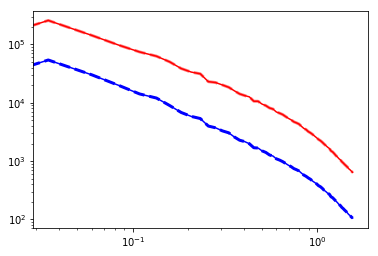

In [302]:
b1, b2, bs2 = 1, 2, 1
pa, px = ftomin([b1, b2, bs2], retp=True)
mod = ed + b1*ed0 + b2*ed2 + bs2*es2
mod =  b1*ed0 + b2*ed2 + bs2*es2

######
p1 = FFTPower(mod, mode='1d').power['power']
pxh1 = FFTPower(hmesh, second=mod, mode='1d').power['power']

######
plt.plot(k, p1, 'r')
plt.plot(k, pa, 'r--', lw=3, alpha=0.5)

plt.plot(k, pxh1, 'b')
plt.plot(k, px, 'b--', lw=3)
plt.loglog()

In [303]:
# b1, b2, bs2 = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
b1, b2, bs2 = minimize(ftomin, [1, 1, 1]).x
# mod = ed + b1*ed0 + b2*ed2 + bs*es2
mod = b1*ed0 + b2*ed2 + bs2*es2
mod2 = fin.copy()

print(b1, b2, bs2)
ftomin([b1, b2, bs2]), ftomin([0, 0, 0])

0.5309138958601234 0.007739886116993956 -0.019269152515900077


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:485: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:487: ComplexWarning: Casting complex valu

((17.24877655705021+5.877536814448236e-08j), (15784.068761747538+0j))

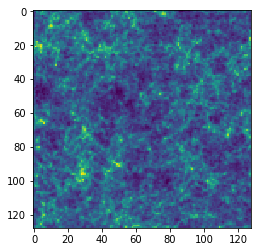

In [304]:
plt.imshow(mod[...].sum(axis=0))

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


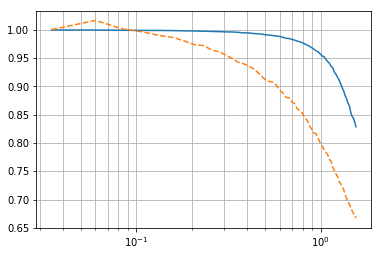

In [308]:
pmod = FFTPower(mod, mode='1d').power['power']
pxmodh = FFTPower(hmesh, second=mod, mode='1d').power['power']

pmod2 = FFTPower(mod2, mode='1d').power['power']
pxmod2h = FFTPower(hmesh, second=mod2, mode='1d').power['power']

# plt.plot(k, (pf/ph)**0.5)
plt.plot(k, pxmodh/(pmod*ph)**0.5)
# plt.plot(k, pxmod2h/(pmod2*ph)**0.5)
plt.plot(k, (pmod/ph)**0.5, '--')
# plt.plot(k, (pmod2/ph)**0.5, '--')
# plt.plot(k, ph)
plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both')

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


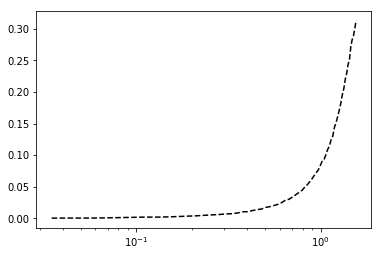

In [309]:
plt.plot(k, 1- pxmodh**2/(pmod*ph)**1, 'k--')
plt.xscale('log')

[]

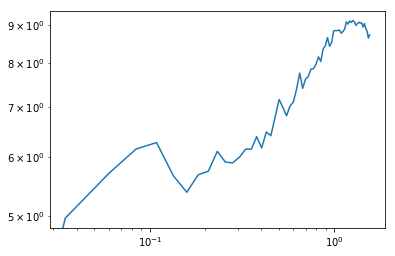

In [311]:
perr = FFTPower(hmesh - mod, mode='1d').power['power']

plt.plot(k, perr)
# plt.axhline(1/numd, color='gray')
plt.loglog()

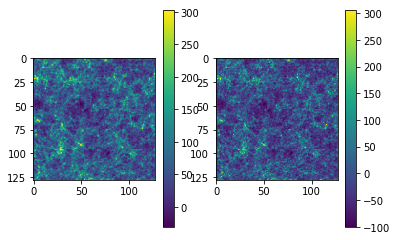

In [312]:
plt.subplot(121)
plt.imshow(mod[...].sum(axis=0))
plt.colorbar()
plt.subplot(122)
plt.imshow(hmesh[...].sum(axis=0))
plt.colorbar()


# Compare models

In [22]:
# data = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/fastpm_0.2000/LL-0.200/')
# data['Mass'] = data['Length']*data.attrs['M0']*1e10
# rsdfac = 0 
# with open('/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/fastpm_0.2000/Header/attr-v2') as ff:
#     for line in ff.readlines():
#         if 'RSDFactor' in line: rsdfac = float(line.split()[-2])
# print(rsdfac)            
# los = np.array([0, 0, 1]).reshape(1, -1)
# hpos, hmass, hvel = data['Position'], data['Mass'], data['Velocity']

# lin = BigFileMesh('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/%d-%d-9100-fixed/linear/'%(bs, nc), 'LinearDensityK').paint()
# ones = pm.create(type='real', value=1.)

# grid = pm.mesh_coordinates()*bs/nc

# zapos = doza(lin.r2c(), grid, z=zz)
# za = pm.paint(zapos)

# num = data.size
# print('Number of halos : ', num)
# # hmesh = pm.paint(data['Position'][:num])
# # noise = bs**3/num

# hmesh = pm.paint(hpos[:num], mass=hmass[:num])
# noise = bs**3 / (hmass[:num].sum()**2/(hmass[:num]**2).sum())
# hmesh /= hmesh.cmean()
# hmesh -= 1
# hmeshrsd = pm.paint(hpos[:num] + los*hvel*rsdfac, mass=hmass[:num])
# hmeshrsd /= hmeshrsd.cmean()
# hmeshrsd -= 1

# # # dyn = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/256-256-9100-fixed/fastpm_0.2000/1')
# # # dyn = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/10stepT-B1/256-256-9100-fixed/fastpm_0.2000/1')
# # # dyn = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B2/256-256-9100-fixed/fastpm_0.2000/1')
# # dyn2 = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B2/256-128-9100-fixed/fastpm_0.2000/1')
# # fin2 = pm.paint(dyn2['Position'])
# # fin2 /= fin2.cmean()
# # fin2 -= 1
# # finsm2 = ft.smooth(fin2, 3, 'gauss')
# # fpos2 = dyn2['Position'].compute()
# # fpos2[fpos2 < 0] += bs
# # fpos2[fpos2 > bs] -= bs

# dyn = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/256-128-9100-fixed/fastpm_0.2000/1')
# fin = pm.paint(dyn['Position'])
# fin /= fin.cmean()
# fin -= 1
# finsm = ft.smooth(fin, 3, 'gauss')

# fpos = dyn['Position'].compute()
# fpos[fpos < 0] += bs
# fpos[fpos > bs] -= bs



0.00797207


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


Number of halos :  28240463


In [9]:


models = []
params = []
for basemesh, pos in [[lin, zapos], [lin, fpos],  [finsm, grid]]:
# for basemesh, pos in [[lin, zapos], [lin, fpos],  [finsm, grid]]:
    d0 = basemesh.copy()
    d2 = 1.*basemesh**2
    d2 -= d2.cmean()
    s2 = ft.shear(pm, basemesh)
    s2 -= 1.*basemesh**2
    s2 -= s2.cmean()

    ph = FFTPower(hmesh, mode='1d').power['power']

    ed = pm.paint(pos, mass=ones.readout(grid, resampler='nearest'))
    ed0 = pm.paint(pos, mass=d0.readout(grid, resampler='nearest'))
    ed2 = pm.paint(pos, mass=d2.readout(grid, resampler='nearest'))
    es2 = pm.paint(pos, mass=s2.readout(grid, resampler='nearest'))

    ped = FFTPower(ed, mode='1d').power['power']
    ped0 = FFTPower(ed0, mode='1d').power['power']
    ped2 = FFTPower(ed2, mode='1d').power['power']
    pes2 = FFTPower(es2, mode='1d').power['power']

    pxedd0 = FFTPower(ed, second=ed0, mode='1d').power['power']
    pxedd2 = FFTPower(ed, second=ed2, mode='1d').power['power']
    pxeds2 = FFTPower(ed, second=es2, mode='1d').power['power']

    pxed0d2 = FFTPower(ed0, second=ed2, mode='1d').power['power']
    pxed0s2 = FFTPower(ed0, second=es2, mode='1d').power['power']
    pxed2s2 = FFTPower(ed2, second=es2, mode='1d').power['power']

    pxhed = FFTPower(hmesh, second=ed, mode='1d').power['power']
    pxhed0 = FFTPower(hmesh, second=ed0, mode='1d').power['power']
    pxhed2 = FFTPower(hmesh, second=ed2, mode='1d').power['power']
    pxhes2 = FFTPower(hmesh, second=es2, mode='1d').power['power']


    def ftomin(bb, ii=20, retp = False):
        b1, b2, bs = bb
        pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
        pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
#         pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 

        predx = 1*b1*pxhed0 + 1*b2*pxhed2
        predx += 1*bs*pxhes2
#         predx += 1*pxhed

        if retp : return pred, predx
    #     chisq = (((ph + pred - 2*predx)[ii])**2).real
        chisq = (((ph + pred - 2*predx)[1:ii])**2).sum()**0.5.real
        return chisq


#     b1, b2, bs2 = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
    b1, b2, bs2 = minimize(ftomin, [1, 0, 0]).x
#     mod = ed + b1*ed0 + b2*ed2 + bs*es2
    mod = b1*ed0 + b2*ed2 + bs2*es2
    print(b1, b2, bs2)
    params.append([b1, b2, bs2])
    models.append(mod)
    


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


0.524359459670699 0.0032181583405164835 -0.029795444826784992


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:485: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:487: ComplexWarning: Casting complex valu

0.5253595915956849 0.014509307894720108 -0.00737211803965266
2.1497544967796465 -0.9215968359472054 -1.6294452980730876


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


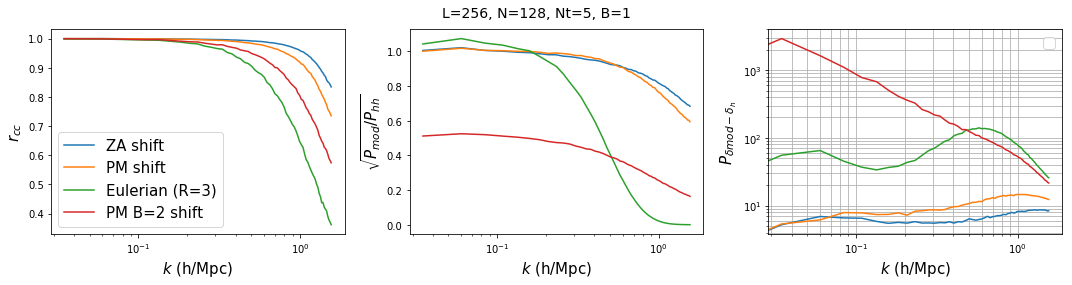

In [11]:
plt.figure(figsize=(15, 4))
fsize = 15

lbls = ['ZA shift', 'PM shift', 'Eulerian (R=3)', 'PM B=2 shift', 'Eulerian B=2 (R=3)']

models.append(fin.copy())
for ii, mod in enumerate(models):
    
    pmod = FFTPower(mod, mode='1d').power
    k, pmod = pmod['k'], pmod['power']
    pxmodh = FFTPower(hmesh, second=mod, mode='1d').power['power']
    perr = FFTPower(hmesh -mod, mode='1d').power['power']
    # plt.plot(k, (pf/ph)**0.5)

    ax = plt.subplot(131)
    plt.plot(k, pxmodh/(pmod*ph)**0.5, label=lbls[ii])
    plt.xscale('log')
    plt.grid(which='both')
    plt.ylabel('$r_{cc}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)
    plt.legend(fontsize=fsize)
        
    ax = plt.subplot(132)
    plt.plot(k,(pmod/ph)**0.5)
    plt.xscale('log')
    plt.grid(which='both')
    plt.ylabel('$\sqrt{P_{mod}/P_{hh}}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)

    ax = plt.subplot(133)
    plt.plot(k, perr)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both')
    plt.ylabel('$P_{\delta{mod}-\delta_h}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)

# plt.axhline(noise)
plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both')
plt.legend(fontsize=fsize)
plt.suptitle('L=%d, N=%d, Nt=%s, B=%d'%(bs, nc, 5, 1), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])


# Redshift Space

In [79]:
# aat = 0.2222
# zzt = 1/aat - 1
# dynt = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/256-256-9100-fixed/fastpm_%0.4f/1'%aat)
# datat = BigFileCatalog('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/256-256-9100-fixed/fastpm_%0.4f/LL-0.200'%aat)
# with open('/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/fastpm_%0.4f/Header/attr-v2'%aat) as ff:
#     for line in ff.readlines():
#         if 'RSDFactor' in line: rsdfact = float(line.split()[-2])
# print(datat['Velocity'][:, 0].std().compute()*rsdfact, dynt['Velocity'][:, 0].std().compute()*rsdfact)

# zdisp = doza(lin.r2c(), grid, z=zzt, displacement=True)
# print(zdisp[:, 0].std())
# (cosmo.scale_independent_growth_rate(zzt)*aat**2*cosmo.efunc(zzt))*zdisp[:, 0].std() * 100/aat*rsdfact, (cosmo.scale_independent_growth_rate(zzt))*zdisp[:, 0].std()

In [169]:
cosmo.scale_independent_growth_factor(zz), cosmo.scale_independent_growth_rate(zz), cosmo.efunc(zz), aa, 1/aa

(array(0.41802798),
 array(0.95753707),
 3.0204356749975965,
 0.3333,
 3.0003000300030003)

In [170]:
zdisp = doza(lin.r2c(), grid, z=zz, displacement=True)
zarsd = cosmo.scale_independent_growth_rate(zz)*zdisp*los
pmrsd = dyn['Velocity']*rsdfac*los
# pmrsd2 = dyn2['Velocity']*rsdfac*los

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


In [171]:
vload = np.load('../code/recon/vpos.npy')
vload.std(axis=0)*100/aa, dyn['Velocity'].std(axis=0).compute()

(array([102.97055231, 102.97055248, 102.96570107]),
 array([212.81996, 212.78406, 213.47298], dtype=float32))

In [172]:
vload.std(axis=0)*rsdfac

array([0.00342472, 0.00342472, 0.00342456])

In [173]:
# print(vload.std(axis=0)*cosmo.efunc(zz)*100)


In [174]:
# print(vload.std(axis=0)*rsdfac*cosmo.efunc(zz)*100)
print(vload.std(axis=0)*rsdfac*100/aa)
zarsd.std(axis=0), pmrsd.std(axis=0).compute()

[1.02751946 1.02751946 1.02747105]


(array([0.        , 0.        , 2.15377243]),
 array([0.        , 0.        , 2.13021683]))

In [175]:
fload = np.load('../code/recon/fpos.npy')
rload = np.load('../code/recon/rpos.npy')
fload-rload

array([[ 0.        ,  0.        , -4.87761349],
       [ 0.        ,  0.        , -4.37108543],
       [ 0.        ,  0.        , -3.67246015],
       ...,
       [ 0.        ,  0.        , -3.46708019],
       [ 0.        ,  0.        , -4.58643075],
       [ 0.        ,  0.        , -4.69680498]])

In [176]:
zarsd

array([[ 0.        , -0.        ,  7.75607028],
       [ 0.        , -0.        ,  6.90572841],
       [ 0.        , -0.        ,  5.86725839],
       ...,
       [ 0.        , -0.        ,  5.68384085],
       [ 0.        , -0.        ,  7.06718364],
       [ 0.        ,  0.        ,  7.57399835]])

In [177]:


models = []
params = []
modelrsddisp = []


# for basemesh, pos, rsd in [[lin, zapos, zarsd], [lin, fpos, pmrsd],  [finsm, grid, pmrsd], [lin, fpos2, pmrsd2], [finsm2, grid, pmrsd2]]:
for basemesh, pos, rsd in [[lin, zapos, zarsd], [lin, fpos, pmrsd],  [finsm, grid, pmrsd]]:
    d0 = basemesh.copy()
    d2 = 1.*basemesh**2
    d2 -= d2.cmean()
    s2 = ft.shear(pm, basemesh)
#     s2 -= 1.*basemesh**2
    s2 -= s2.cmean()

    ph = FFTPower(hmesh, mode='1d').power['power']

    ed = pm.paint(pos, mass=ones.readout(grid, resampler='nearest'))
    ed0 = pm.paint(pos, mass=d0.readout(grid, resampler='nearest'))
    ed2 = pm.paint(pos, mass=d2.readout(grid, resampler='nearest'))
    es2 = pm.paint(pos, mass=s2.readout(grid, resampler='nearest'))

#     ped = FFTPower(ed, mode='1d').power['power']
    ped0 = FFTPower(ed0, mode='1d').power['power']
    ped2 = FFTPower(ed2, mode='1d').power['power']
    pes2 = FFTPower(es2, mode='1d').power['power']

#     pxedd0 = FFTPower(ed, second=ed0, mode='1d').power['power']
#     pxedd2 = FFTPower(ed, second=ed2, mode='1d').power['power']
#     pxeds2 = FFTPower(ed, second=es2, mode='1d').power['power']

    pxed0d2 = FFTPower(ed0, second=ed2, mode='1d').power['power']
    pxed0s2 = FFTPower(ed0, second=es2, mode='1d').power['power']
    pxed2s2 = FFTPower(ed2, second=es2, mode='1d').power['power']

#     pxhed = FFTPower(hmesh, second=ed, mode='1d').power['power']
    pxhed0 = FFTPower(hmesh, second=ed0, mode='1d').power['power']
    pxhed2 = FFTPower(hmesh, second=ed2, mode='1d').power['power']
    pxhes2 = FFTPower(hmesh, second=es2, mode='1d').power['power']


    def ftomin(bb, ii=20, retp = False):
        b1, b2, bs = bb
        pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
        pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
#         pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 

        predx = 1*b1*pxhed0 + 1*b2*pxhed2
        predx += 1*bs*pxhes2
#         predx += 1*pxhed

        if retp : return pred, predx
    #     chisq = (((ph + pred - 2*predx)[ii])**2).real
        chisq = (((ph + pred - 2*predx)[1:ii])**2).sum()**0.5.real
        return chisq


#     b1, b2, bs2 = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
    b1, b2, bs2 = minimize(ftomin, [1, 0, 0]).x
#     mod = ed + b1*ed0 + b2*ed2 + bs*es2
    mod = b1*ed0 + b2*ed2 + bs2*es2
    print(b1, b2, bs2)
    params.append([b1, b2, bs2])
    models.append(mod)

    ed0 = pm.paint(pos+rsd, mass=d0.readout(grid, resampler='nearest'))
    ed2 = pm.paint(pos+rsd, mass=d2.readout(grid, resampler='nearest'))
    es2 = pm.paint(pos+rsd, mass=s2.readout(grid, resampler='nearest'))
    modrsd = b1*ed0 + b2*ed2 + bs2*es2
    modelrsddisp.append(modrsd)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


0.5243597163161607 0.03301344630046215 -0.029794754738066472


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex 

0.5253595568250237 0.021881408905442438 -0.007372043417405491


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


2.149753951663208 0.7078486250601431 -1.6294443195943518


In [178]:
modelrsdreadout  = []

ii = 0
# for pos, zdisp in [[zapos, zarsd], [fpos, pmrsd], [fpos, pmrsd], [fpos2, pmrsd2], [fpos2, pmrsd2]]:
for pos, zdisp in [[zapos, zarsd], [fpos, pmrsd], [fpos, pmrsd]]:
    vmesh = pm.paint(pos, mass=zdisp[:, -1])
    newpos = grid + vmesh.readout(grid).reshape(-1, 1)*los
    wts = models[ii].readout(grid)
    modelrsdreadout.append(pm.paint(newpos, mass=wts))
    ii +=1

In [179]:


params3 = []
modelrsdfit = []


# for basemesh, pos, rsd in [[lin, zapos, zarsd], [lin, fpos, pmrsd],  [finsm, grid, pmrsd], [lin, fpos2, pmrsd2], [finsm2, grid, pmrsd2]]:
for basemesh, pos, rsd in [[lin, zapos, zarsd], [lin, fpos, pmrsd],  [finsm, grid, pmrsd]]:
    d0 = basemesh.copy()
    d2 = 1.*basemesh**2
    d2 -= d2.cmean()
    s2 = ft.shear(pm, basemesh)
#     s2 -= 1.*basemesh**2
    s2 -= s2.cmean()

    ph = FFTPower(hmeshrsd, mode='1d').power['power']

    ed = pm.paint(pos+rsd, mass=ones.readout(grid, resampler='nearest'))
    ed0 = pm.paint(pos+rsd, mass=d0.readout(grid, resampler='nearest'))
    ed2 = pm.paint(pos+rsd, mass=d2.readout(grid, resampler='nearest'))
    es2 = pm.paint(pos+rsd, mass=s2.readout(grid, resampler='nearest'))

#     ped = FFTPower(ed, mode='1d').power['power']
    ped0 = FFTPower(ed0, mode='1d').power['power']
    ped2 = FFTPower(ed2, mode='1d').power['power']
    pes2 = FFTPower(es2, mode='1d').power['power']

#     pxedd0 = FFTPower(ed, second=ed0, mode='1d').power['power']
#     pxedd2 = FFTPower(ed, second=ed2, mode='1d').power['power']
#     pxeds2 = FFTPower(ed, second=es2, mode='1d').power['power']

    pxed0d2 = FFTPower(ed0, second=ed2, mode='1d').power['power']
    pxed0s2 = FFTPower(ed0, second=es2, mode='1d').power['power']
    pxed2s2 = FFTPower(ed2, second=es2, mode='1d').power['power']

#     pxhed = FFTPower(hmesh, second=ed, mode='1d').power['power']
    pxhed0 = FFTPower(hmeshrsd, second=ed0, mode='1d').power['power']
    pxhed2 = FFTPower(hmeshrsd, second=ed2, mode='1d').power['power']
    pxhes2 = FFTPower(hmeshrsd, second=es2, mode='1d').power['power']


    def ftomin(bb, ii=20, retp = False):
        b1, b2, bs = bb
        pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
        pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
#         pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 

        predx = 1*b1*pxhed0 + 1*b2*pxhed2
        predx += 1*bs*pxhes2
#         predx += 1*pxhed

        if retp : return pred, predx
    #     chisq = (((ph + pred - 2*predx)[ii])**2).real
        chisq = (((ph + pred - 2*predx)[1:ii])**2).sum()**0.5.real
        return chisq


#     b1, b2, bs2 = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
    b1, b2, bs2 = minimize(ftomin, [1, 0, 0]).x
#     mod = ed + b1*ed0 + b2*ed2 + bs*es2
    mod = b1*ed0 + b2*ed2 + bs2*es2
    print(b1, b2, bs2)
    params3.append([b1, b2, bs2])
    modelrsdfit.append(mod)




/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:485: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:487: ComplexWarning: Casting complex valu

0.5887743154900849 0.016211715561189638 -0.016764056162567462


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


0.5886524199478279 0.0019873580325625853 0.011821682674667397
2.4329662021531737 0.5221124485647437 -1.2432131602179723


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:485: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:487: ComplexWarning: Casting complex valu

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
No handles with labels found to put in legend.


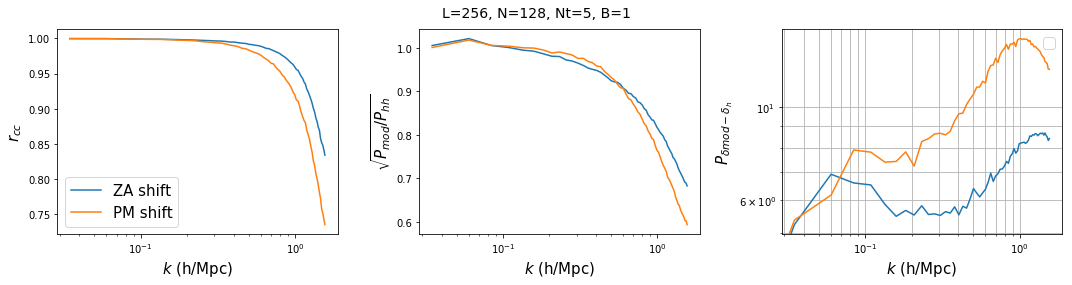

In [285]:
plt.figure(figsize=(15, 4))
fsize = 15

lbls = ['ZA shift', 'PM shift', 'Eulerian (R=3)', 'PM B=2 shift', 'Eulerian B=2 (R=3)']

for ii, mod in enumerate(models[:2]):
    ph = FFTPower(hmesh, mode='1d').power['power']
    pmod = FFTPower(mod, mode='1d').power
    k, pmod = pmod['k'], pmod['power']
    pxmodh = FFTPower(hmesh, second=mod, mode='1d').power['power']
    perr = FFTPower(hmesh - mod, mode='1d').power['power']
    # plt.plot(k, (pf/ph)**0.5)

    ax = plt.subplot(131)
    plt.plot(k, pxmodh/(pmod*ph)**0.5, label=lbls[ii])
    plt.xscale('log')
    plt.grid(which='both')
    plt.ylabel('$r_{cc}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)
    plt.legend(fontsize=fsize)
        
    ax = plt.subplot(132)
    plt.plot(k,(pmod/ph)**0.5)
    plt.xscale('log')
    plt.grid(which='both')
    plt.ylabel('$\sqrt{P_{mod}/P_{hh}}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)

    ax = plt.subplot(133)
    plt.plot(k, perr)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both')
    plt.ylabel('$P_{\delta{mod}-\delta_h}$', fontsize=fsize)
    plt.xlabel('$k$ (h/Mpc)', fontsize=fsize)

# plt.axhline(noise)
plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both')
plt.legend(fontsize=fsize)
plt.suptitle('L=%d, N=%d, Nt=%s, B=%d'%(bs, nc, 5, 1), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


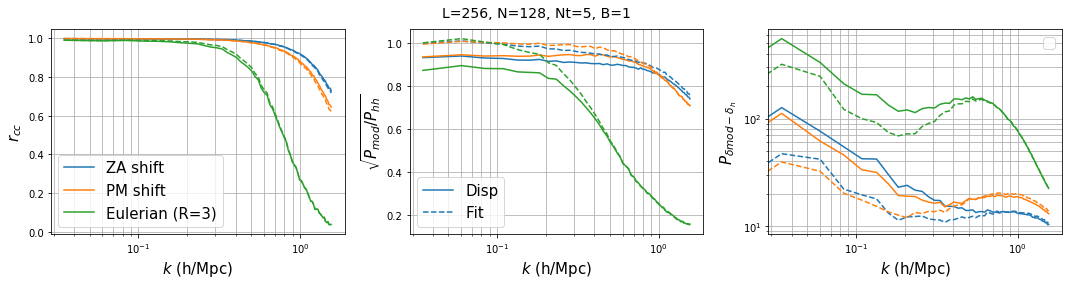

In [182]:
fig = plt.figure(figsize=(15, 4))
fsize = 15

lbls = ['ZA shift', 'PM shift', 'Eulerian (R=3)', 'PM B=2 shift', 'Eulerian B=2 (R=3)']

allmodels = [modelrsddisp, modelrsdfit, modelrsdreadout]
allmodels = [modelrsddisp, modelrsdfit]
lblm = ['Disp', 'Fit', 'Readout']
lss = ['-', '--', ':', '-.']


for jj, mmod in enumerate(allmodels):
    for ii, mod in enumerate(mmod):
        ph = FFTPower(hmeshrsd, mode='1d').power['power']
        pmod = FFTPower(mod, mode='1d').power
        k, pmod = pmod['k'], pmod['power']
        pxmodh = FFTPower(hmeshrsd, second=mod, mode='1d').power['power']
        perr = FFTPower(hmeshrsd -mod, mode='1d').power['power']

        ax = plt.subplot(131)
        lbl = lbls[ii]
        if jj: lbl = None
        plt.plot(k, pxmodh/(pmod*ph)**0.5, 'C%d'%ii, ls=lss[jj], label=lbl)
        plt.ylabel('$r_{cc}$', fontsize=fsize)

        ax = plt.subplot(132)
        lbl = lblm[jj]
        if ii: lbl = None
        plt.plot(k,(pmod/ph)**0.5, 'C%d'%ii, ls=lss[jj], label=lbl)
        plt.ylabel('$\sqrt{P_{mod}/P_{hh}}$', fontsize=fsize)

        ax = plt.subplot(133)
        plt.plot(k, perr, 'C%d'%ii, ls=lss[jj])
        plt.yscale('log')
        plt.ylabel('$P_{\delta{mod}-\delta_h}$', fontsize=fsize)

axar = fig.get_axes()
for ax in axar:
    ax.set_xscale('log')
    ax.set_xlabel('$k$ (h/Mpc)', fontsize=fsize)
    ax.legend(fontsize=fsize)
    ax.grid(which='both')
    
plt.suptitle('L=%d, N=%d, Nt=%s, B=%d'%(bs, nc, 5, 1), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Upsample

In [247]:
nc2 = 2*nc
pm2 = PMnew(BoxSize=pm.BoxSize, Nmesh=2*pm.Nmesh)

In [276]:
hmeshup = pm2.upsample(hmesh, keep_mean=True)
modup = pm2.upsample(models[0], keep_mean=True)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


[]

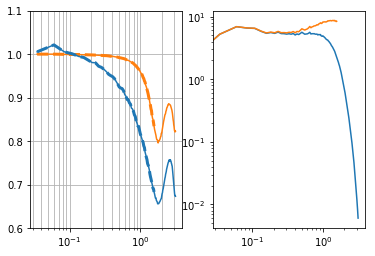

In [284]:
p1 = FFTPower(hmesh, mode='1d').power
k, p1 = p1['k'], p1['power']
p2 = FFTPower(models[0], mode='1d').power['power']
p12 = FFTPower(hmesh, second=models[0], mode='1d').power['power']
perr = FFTPower(hmesh - models[0], mode='1d').power['power']


p1up = FFTPower(hmeshup, mode='1d').power
kup, p1up = p1up['k'], p1up['power']
p2up = FFTPower(modup, mode='1d').power['power']
p12up = FFTPower(hmeshup, second=modup, mode='1d').power['power']
perrup = FFTPower(hmeshup - modup, mode='1d').power['power']


ax = plt.subplot(121)
plt.plot(kup, p12up/(p2up*p1up)**0.5, 'C1')
plt.plot(k, p12/(p2*p1)**0.5, 'C1--', lw=3)

plt.plot(kup, (p2up/p1up)**0.5, 'C0')
plt.plot(k, (p2/p1)**0.5, 'C0--', lw=3)
plt.xscale('log')
# plt.plot(kup, p2up/p1up)
plt.grid(which='both')
plt.ylim(.6, 1.1)

ax = plt.subplot(122)
plt.plot(kup, perrup)
plt.plot(k, perr)
plt.loglog()

### Test init

In [229]:
spath = '/global/cscratch1/sd/chmodi/m3127/21cm_cleaning/recon/fastpm_0.3333/wedge_kmin0.01_ang50.0/L0256-N0128/ZA/opt_s999_h1massA_fourier/128-0.00/best-fit'
sinit = BigFileMesh(spath, 's').paint()


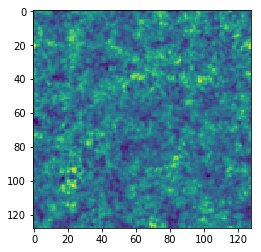

In [234]:
plt.imshow(sinit[...].sum(axis=2))

In [278]:
sinitup = pm2.upsample(sinit, keep_mean=True)
linup = pm2.upsample(lin, keep_mean=True)


In [274]:
lin2 = BigFileMesh('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/%d-%d-9100-fixed/linear/'%(bs, nc*2), 'LinearDensityK').paint()
# hmesh2 = BigFileMesh('/global/cscratch1/sd/chmodi/m3127/cm_lowres/5stepT-B1/%d-%d-9100-fixed/fastpm_%0.4f/Hmesh_N'%(bs, nc*2, aa), 'LinearDensityK').paint()
hmesh2 = BigFileMesh('/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/fastpm_%0.4f/HImesh-N%04d/'%(aa, nc*2), 'ModelA').paint()
hmesh2 /= hmesh2.cmean()
hmesh2 -= 1

In [279]:
grid2 = pm2.mesh_coordinates()*bs/nc2
zapos2 = doza(lin2.r2c(), grid2, z=zz)
zaposup = doza(linup.r2c(), grid2, z=zz)
zaposinup = doza(sinitup.r2c(), grid2, z=zz)
zaposin = doza(sinit.r2c(), grid, z=zz)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


In [280]:
def getmod(basemesh, pos, params, bs=bs):
    pm = basemesh.pm
    d0 = basemesh.copy()                                                                          
    d2 = 1.*basemesh**2                                                                           
    d2 -= d2.cmean()                                                                              
    s2 = ft.shear(pm, basemesh)                                                                      
    s2 -= 1.*basemesh**2                                                                          
    s2 -= s2.cmean()                                                                              
    grid = pm.mesh_coordinates()*bs/pm.Nmesh[0]
    glay, play = pm.decompose(grid), pm.decompose(pos)
    ed0 = pm.paint(pos, mass=d0.readout(grid, layout = glay, resampler='nearest'), layout=play)
    ed2 = pm.paint(pos, mass=d2.readout(grid, layout = glay, resampler='nearest'), layout=play)
    es2 = pm.paint(pos, mass=s2.readout(grid, layout = glay, resampler='nearest'), layout=play)
    b1, b2, bs = params
    mod = b1*ed0 + b2*ed2 + bs*es2
    return mod

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


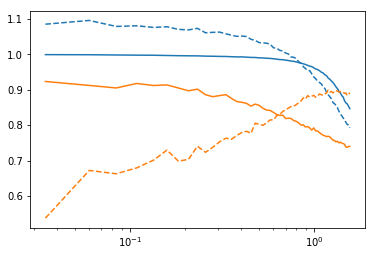

In [281]:
ii = 0
for base, pos in [[lin, zapos], [sinit, zaposin]]:
    mod = getmod(base, pos, params[0])
    p1 = FFTPower(hmesh, mode='1d').power['power']
    p2 = FFTPower(mod, mode='1d').power['power']
    p12 = FFTPower(hmesh, second=mod, mode='1d').power['power']
    plt.plot(k, p12/(p1*p2)**0.5, 'C%d'%ii)
    plt.plot(k, p2**0.5/(p1)**0.5, 'C%d--'%ii)
    ii += 1
plt.xscale('log')

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


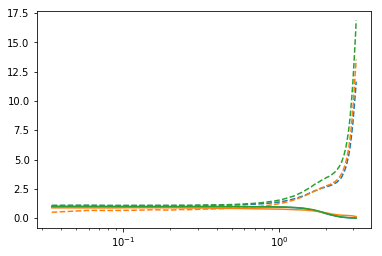

In [282]:
ii = 0
for base, pos in [[linup, zaposup], [sinitup, zaposinup], [lin2, zapos2]]:
    mod = getmod(base, pos, params[0])
    p1 = FFTPower(hmeshup, mode='1d').power['power']
    p2 = FFTPower(mod, mode='1d').power['power']
    p12 = FFTPower(hmeshup, second=mod, mode='1d').power['power']
    plt.plot(kup, p12/(p1*p2)**0.5, 'C%d'%ii)
    plt.plot(kup, p2**0.5/(p1)**0.5, 'C%d--'%ii)
    ii += 1
plt.xscale('log')
plt.ylim(0, 2)

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


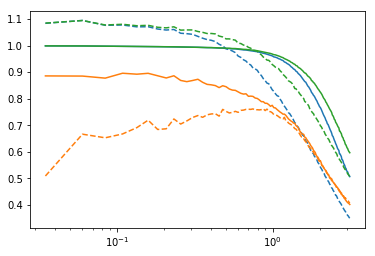

In [283]:
ii = 0
for base, pos in [[linup, zaposup], [sinitup, zaposinup], [lin2, zapos2]]:
    mod = getmod(base, pos, params[0])
    p1 = FFTPower(hmesh2, mode='1d').power['power']
    p2 = FFTPower(mod, mode='1d').power['power']
    p12 = FFTPower(hmesh2, second=mod, mode='1d').power['power']
    plt.plot(kup, p12/(p1*p2)**0.5, 'C%d'%ii)
    plt.plot(kup, p2**0.5/(p1)**0.5, 'C%d--'%ii)
    ii += 1
plt.xscale('log')


# Fourier bias model

In [313]:
def ftomink(bb, ii, retp = False):
    b1, b2, bs = bb
    pred = b1**2 *ped0 + b2**2*ped2 + 2*b1*b2*pxed0d2 
    pred += bs**2 *pes2 + 2*b1*bs*pxed0s2 + 2*b2*bs*pxed2s2
#     pred += ped + 2*b1*pxedd0 + 2*b2*pxedd2 + 2*bs*pxeds2 
    
    predx = 1*b1*pxhed0 + 1*b2*pxhed2
    predx += 1*bs*pxhes2
#     predx += 1*pxhed
    
    if retp : return pred, predx
    chisq = (((ph + pred - 2*predx)[ii])**2).real
    return chisq


# b1, b2, bs = minimize(ftomin, [1, 1, 1], method='Nelder-Mead', options={'maxfev':10000}).x
b1k, b2k, bsk = np.zeros_like(k), np.zeros_like(k), np.zeros_like(k)
for ii in range(k.size):
    tfunc = lambda p: ftomink(p,ii)
#     b1k[ii], b2k[ii], bsk[ii] = minimize(tfunc, [1, 1, 1], method='Nelder-Mead', options={'maxfev':1000}).x
    b1k[ii], b2k[ii], bsk[ii] = minimize(tfunc, [1, 1, 1]).x

# mod = ed + b1*ed0 + b2*ed2 + bs*es2b
# mod = b1*ed0 + b2*ed2 + bs*es2
# mod2 = ed

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


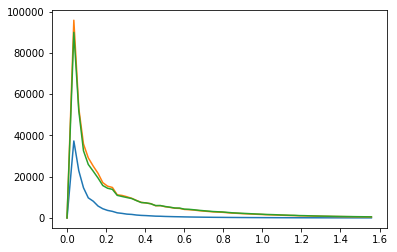

In [314]:
plt.plot(k, ped0)
plt.plot(k, ped2)
plt.plot(k, pes2)


(-0.1, 0.6)

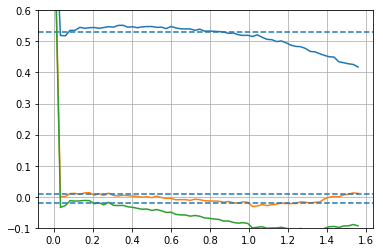

In [331]:
plt.plot(k, b1k)
plt.axhline(b1, ls='--')
plt.plot(k, b2k)
plt.axhline(b2, ls='--')
plt.plot(k, bsk)
plt.axhline(bs2, ls='--')
# plt.xscale('log')
plt.grid(which='both')
plt.ylim(-0.1, .6)


# Masks

In [14]:
def wnoise(pmc, ipk):
    k = pmc.x
    k2 = sum(ki**2 for ki in k)
    r = (ipk(k2 ** 0.5) / pmc.BoxSize.prod()) ** -0.5
    r[k2 == 0] = 1.0
    pmc *= r-f
    
    return pmc.c2r()

ipklin = ius(klin, plin)
w1 = wnoise(lin.r2c(), ipklin)

w1.csum()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


2.3283064365386963e-10

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


From kpar mask :  0.07692307692307693
From leakage :  0.814208984375
Fraction of zeros :  0.8142728365384615
From kpar mask :  0.06614785992217899
From leakage :  0.8153099920963035
Fraction of zeros :  0.8153595089448565


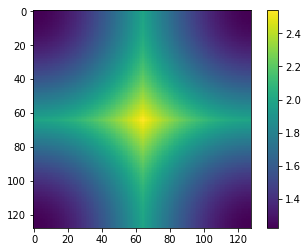

In [227]:
def getmask(kk, kmin, ang):
    mask = [np.ones_like(ki) for ki in kk]
    kmesh = sum(i**2 for i in kk1)**0.5
    mask[2] *= abs(kk[2]) >= kmin
    mask = np.prod(mask)
    print('From kpar mask : ', (mask == 0).sum()/mask.size)

    mask2 = np.ones_like(mask)
    if ang > 0:
        kperp = (kk[0]**2 + kk[1]**2)**0.5
        kangle = abs(kk[2])/(kperp+1e-10)
        angles = (np.arctan(kangle)*180/np.pi)
        mask2[angles < ang] = 0
    print('From leakage : ', (mask2 == 0).sum()/mask2.size)
    fgmask = mask*mask2
    print('Fraction of zeros : ', (fgmask == 0).sum()/fgmask.size)
    return kmesh, mask, mask2, fgmask


kk2 = tools.fftk([512, 512, 512], 1024)
kk1 = tools.fftk([128, 128, 128], 256)

tmp1 = getmask(kk1, 0.1, 50)
tmp2 = getmask(kk2, 0.1, 50)


plt.imshow(tmp1[0][...,50])
plt.colorbar()
plt.show()


0.7363107781851077


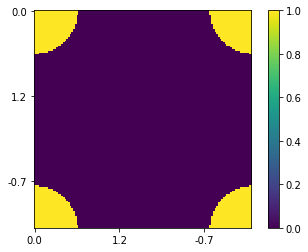

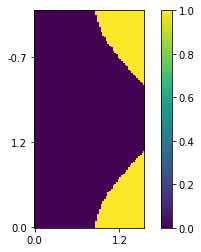

In [253]:

# im = plt.imshow(tmp1[2].sum(axis=-1))
ik = 30
print(kk1[2].flatten()[ik])
im = plt.imshow(tmp1[3][...,ik])
plt.yticks(np.arange(0, kk1[1].size, 50), ['%.1f'%i for i in kk1[1][0, :][::50]])
plt.xticks(np.arange(0, kk1[0].size, 50), ['%.1f'%i for i in kk1[0][::50]])
plt.colorbar()
plt.show()

# im = plt.imshow(tmp1[2].sum(axis=-1))
im = plt.imshow(tmp1[3][:, 30, :], origin='lower')
# im = plt.imshow(tmp1[3][:, 30, :])
plt.yticks(np.arange(0, kk1[0].size, 50), ['%.1f'%i for i in kk1[0][:, 0, 0][::50]])
plt.xticks(np.arange(0, kk1[2].size, 50), ['%.1f'%i for i in kk1[2][0, 0, :][::50]])
plt.colorbar()

In [259]:
tmp = BigFileMesh('../code/recon/fgmasktest/', 'perror').paint()

In [260]:
tmpc = tmp.r2c().real
tmp2 = np.log10(1e-20+abs(tmpc.flatten()))

In [261]:
(tmp2 < -5).sum()/tmp2.size

0.8142127403846153

In [262]:
from matplotlib.colors import SymLogNorm

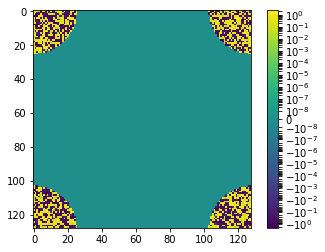

In [264]:
plt.imshow(tmpc[...,ik], norm=SymLogNorm(1e-8))
plt.colorbar()

In [ ]:
P